## 1.Importing Necessary libraries

In [1]:
# Importing required libraries
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

## 2. Initializing a Spark

In [2]:
# Installing pyspark
! pip install pyspark

Defaulting to user installation because normal site-packages is not writeable


In [3]:
# Importing SparkSession
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Churn Prediction with PySpark").getOrCreate()


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/09/01 20:21:03 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/09/01 20:21:05 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [4]:
spark

## 2. Fetching and Importing Data

In [5]:
# Loading data 
CV_data = spark.read.csv('train.csv', header='true', inferSchema='true')

final_test_data = spark.read.csv('test.csv', header='true', inferSchema='true')




In [6]:
df=CV_data

In [7]:
# Printing schema of data
CV_data.printSchema()

root
 |-- State: string (nullable = true)
 |-- Account length: integer (nullable = true)
 |-- Area code: integer (nullable = true)
 |-- International plan: string (nullable = true)
 |-- Voice mail plan: string (nullable = true)
 |-- Number vmail messages: integer (nullable = true)
 |-- Total day minutes: double (nullable = true)
 |-- Total day calls: integer (nullable = true)
 |-- Total day charge: double (nullable = true)
 |-- Total eve minutes: double (nullable = true)
 |-- Total eve calls: integer (nullable = true)
 |-- Total eve charge: double (nullable = true)
 |-- Total night minutes: double (nullable = true)
 |-- Total night calls: integer (nullable = true)
 |-- Total night charge: double (nullable = true)
 |-- Total intl minutes: double (nullable = true)
 |-- Total intl calls: integer (nullable = true)
 |-- Total intl charge: double (nullable = true)
 |-- Customer service calls: integer (nullable = true)
 |-- Churn: boolean (nullable = true)



In [8]:
# Printing count of training and testing data
print("The training dataset contains {} samples.".format(CV_data.count()))
print("The test dataset contains {} samples.".format(final_test_data.count()))

The training dataset contains 2666 samples.
The test dataset contains 667 samples.


In [9]:
# Displaying transpose of data
CV_data.select("*").toPandas().head().transpose()

,0,1,2,3,4
State,KS,OH,NJ,OH,OK
Account length,128,107,137,84,75
Area code,415,415,415,408,415
International plan,No,No,No,Yes,Yes
Voice mail plan,Yes,Yes,No,No,No
Number vmail messages,25,26,0,0,0
Total day minutes,265.1,161.6,243.4,299.4,166.7
Total day calls,110,123,114,71,113
Total day charge,45.07,27.47,41.38,50.9,28.34
Total eve minutes,197.4,195.5,121.2,61.9,148.3


## 3. Summary statistics

In [10]:
# Calculate summary statistics and transpose it
numeric_features = [t[0] for t in CV_data.dtypes if t[1] == 'int' or t[1] == 'double']

CV_data.describe(numeric_features).toPandas().transpose()


23/09/01 20:21:28 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,0,1,2,3,4
summary,count,mean,stddev,min,max
Account length,2666,100.62040510127532,39.56397365334985,1,243
Area code,2666,437.43885971492875,42.521018019427174,408,510
Number vmail messages,2666,8.021755438859715,13.61227701829193,0,50
Total day minutes,2666,179.48162040510135,54.21035022086982,0.0,350.8
Total day calls,2666,100.31020255063765,19.988162186059512,0,160
Total day charge,2666,30.512404351087813,9.215732907163497,0.0,59.64
Total eve minutes,2666,200.38615903976006,50.95151511764598,0.0,363.7
Total eve calls,2666,100.02363090772693,20.16144511531889,0,170
Total eve charge,2666,17.033072018004518,4.330864176799864,0.0,30.91


## 4. Correlations and Data Preparations

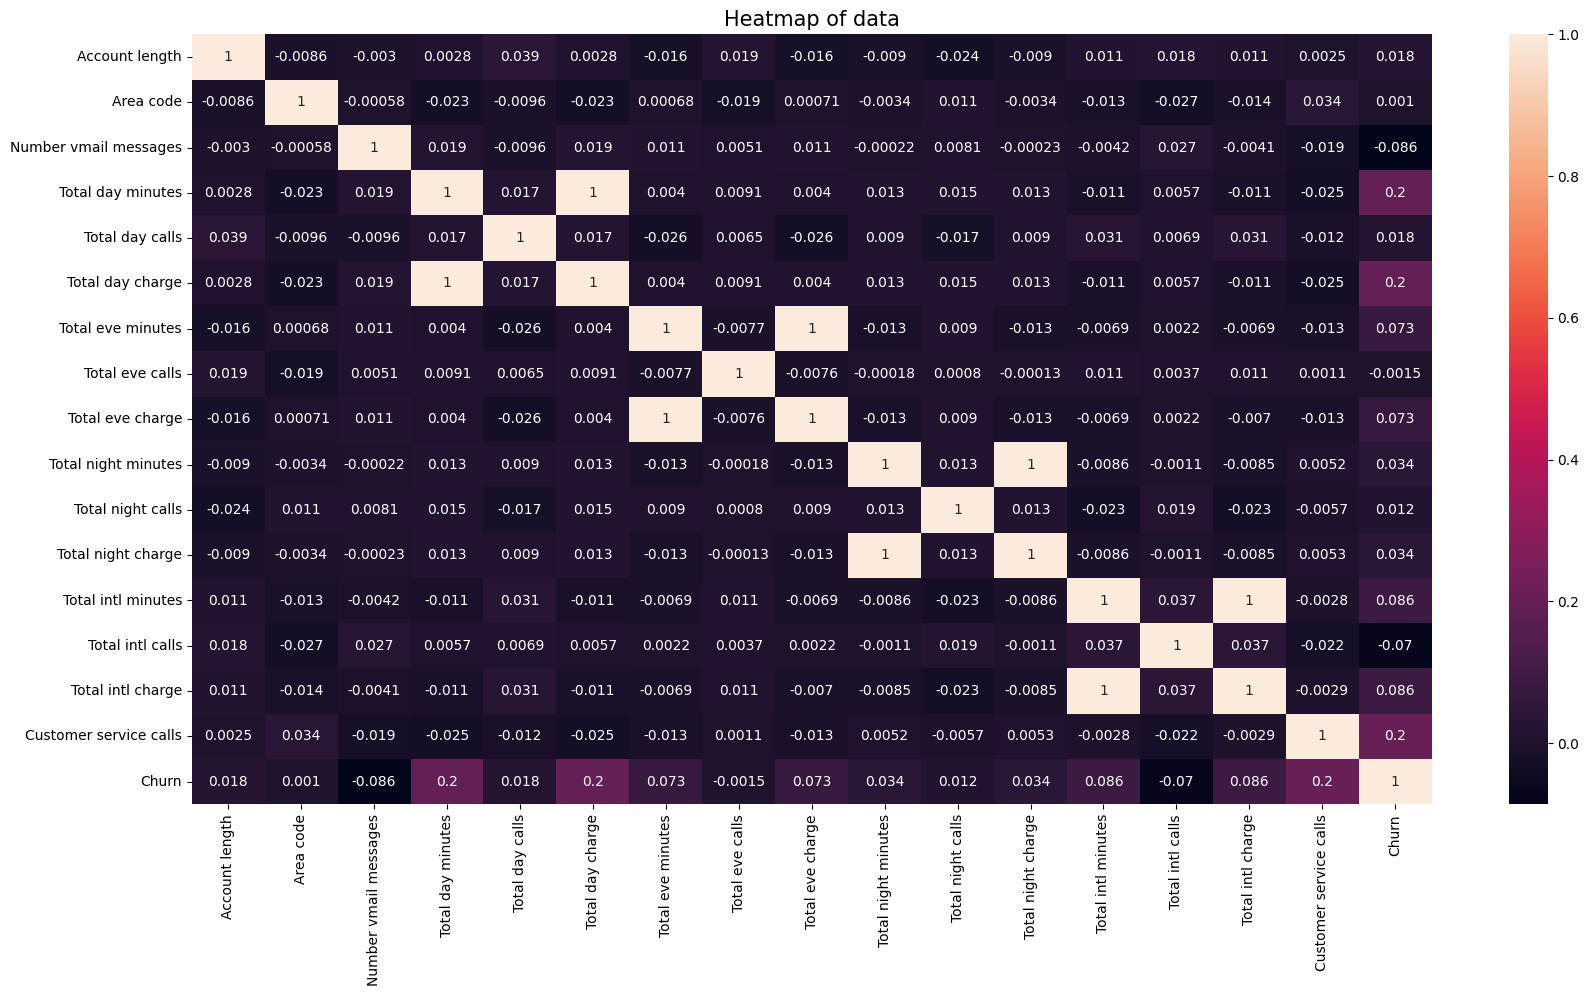

In [11]:
# Displaying Heatmap for Numeric features
data = CV_data.toPandas()
plt.rcParams["figure.figsize"] = (20,10)
sns.heatmap(data[:].corr(numeric_only=True),annot = True)
plt.title("Heatmap of data",fontsize= 15)
plt.show()


In [12]:

# Function for converting and removing columns
def get_data(df, removeCols):
    df = df.drop(*removeCols) \
        .withColumn("Churn", when(df["Churn"] == 'true', 1.0).otherwise(0.0)) \
        .withColumn('International plan', when(df["International plan"] == 'Yes', 1.0).otherwise(0.0)) \
        .withColumn('Voice mail plan', when(df["Voice mail plan"] == 'Yes', 1.0).otherwise(0.0))
    return df



In [13]:
# Importing pyspark.sql.functions for data manipulation and removing columns
from pyspark.sql.functions import split, col, round, when

removeCols = ['State', 'Area code', 'Total day charge', 'Total eve charge', 'Total night charge', 'Total intl charge']

# Removing columns of training and testing data
CV_data = get_data(CV_data, removeCols=removeCols)
final_test_data = get_data(final_test_data, removeCols=removeCols)

In [14]:
# Transposing the data
pd.DataFrame(CV_data.take(5), columns=CV_data.columns).transpose()



,0,1,2,3,4
Account length,128.0,107.0,137.0,84.0,75.0
International plan,0.0,0.0,0.0,1.0,1.0
Voice mail plan,1.0,1.0,0.0,0.0,0.0
Number vmail messages,25.0,26.0,0.0,0.0,0.0
Total day minutes,265.1,161.6,243.4,299.4,166.7
Total day calls,110.0,123.0,114.0,71.0,113.0
Total eve minutes,197.4,195.5,121.2,61.9,148.3
Total eve calls,99.0,103.0,110.0,88.0,122.0
Total night minutes,244.7,254.4,162.6,196.9,186.9
Total night calls,91.0,103.0,104.0,89.0,121.0


## 5. Using Spark MLib Package

### 5.2 Model training

In [15]:
#Importing  labelledpoint and decision tree from mllib library
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.tree import DecisionTree

# Convert DataFrame into a LabeledPoint
def labelData(data):
    # label: row[end], features: row[0:end-1]
    return data.rdd.map(lambda row: LabeledPoint(row[-1], row[:-1]))

# Spliting the data
training_data, testing_data = labelData(CV_data).randomSplit([0.8, 0.2])

# Printing the first two rows
print("The two first rows of the training data RDD:")
print(training_data.take(2))
print("============================")

# Train a Decision Tree classifier model
model = DecisionTree.trainClassifier(training_data, numClasses=2, maxDepth=2,
                                     categoricalFeaturesInfo={1:2, 2:2},
                                    impurity='gini', maxBins=32)
# Print debug string
print(model.toDebugString())

The two first rows of the training data RDD:


[LabeledPoint(0.0, [128.0,0.0,1.0,25.0,265.1,110.0,197.4,99.0,244.7,91.0,10.0,3.0,1.0]), LabeledPoint(0.0, [107.0,0.0,1.0,26.0,161.6,123.0,195.5,103.0,254.4,103.0,13.7,3.0,1.0])]


DecisionTreeModel classifier of depth 2 with 7 nodes
  If (feature 12 <= 3.5)
   If (feature 4 <= 262.0)
    Predict: 0.0
   Else (feature 4 > 262.0)
    Predict: 1.0
  Else (feature 12 > 3.5)
   If (feature 4 <= 171.64999999999998)
    Predict: 1.0
   Else (feature 4 > 171.64999999999998)
    Predict: 0.0



In [16]:
# Displaying significant features
print("Feature 12 is the {}.".format(CV_data.columns[12]))
print("Feature 4 is the {}.".format(CV_data.columns[4]))

Feature 12 is the Customer service calls.
Feature 4 is the Total day minutes.


### 5.3 Model Evaluation

In [17]:
#  Prints various classification metrics based on the predictions made by a machine learning model.
def printAllMetrics(predictionsDF):
    TP = predictionsDF.select("label", "predictedLabel").filter("label == 1.0 and predictedLabel == 1.0").count()
    FN = predictionsDF.select("label", "predictedLabel").filter("label == 1.0 and predictedLabel == 0.0").count()
    TN = predictionsDF.select("label", "predictedLabel").filter("label == 0.0 and predictedLabel == 0.0").count()
    FP = predictionsDF.select("label", "predictedLabel").filter("label == 0.0 and predictedLabel == 1.0").count()

    precision_p   = TP/(TP+FP)
    precision_n   = TN/(TN+FN)
    recall_p      = TP/(TP+FN)
    recall_n      = TN/(TN+FP)
    f1_p          = 2*precision_p*recall_p/(precision_p+recall_p)
    f1_n          = 2*precision_n*recall_n/(precision_n+recall_n)
    avg_precision = (precision_p*(TP+FN)+precision_n*(TN+FP))/(TP+FN+TN+FP)
    avg_recall    = (recall_p*(TP+FN)+recall_n*(TN+FP))/(TP+FN+TN+FP)
    avg_f1        = (f1_p*(TP+FN)+f1_n*(TN+FP))/(TP+FN+TN+FP)
    accuracy      = (TN+TP)/(TP+FN+TN+FP)

    print('Precision of True    ', precision_p)
    print('Precision of False   ', precision_n)
    print('** Avg Precision     ', avg_precision)
    print('Recall of True       ', recall_p)
    print('Recall of False      ', recall_n)
    print('** Avg Recall        ', avg_recall)
    print('F1 of True           ', f1_p)
    print('F1 of False          ', f1_n)
    print('** Avg F1            ', avg_f1)
    print('** Accuracy          ', accuracy)

In [19]:
# Importing Multiclassmetric for evaluating a machine learning model's performance,
from pyspark.mllib.evaluation import MulticlassMetrics

# Takes a trained model and a test dataset as input.
def getPredictionsLabels(model, test_data):
    predictions = model.predict(test_data.map(lambda r: r.features))
    return predictions.zip(test_data.map(lambda r: r.label))

# Calculates and prints various classification metrics
def printMetrics(predictions_and_labels):
    metrics = MulticlassMetrics(predictions_and_labels)
    print('Confusion Matrix\n', metrics.confusionMatrix().toArray())
    print('Precision of True    ', metrics.precision(1))
    print('Precision of False   ', metrics.precision(0))
    print('Weighted Precision   ', metrics.weightedPrecision)
    print('Recall of True       ', metrics.recall(1))
    print('Recall of False      ', metrics.recall(0))
    print('Weighted Recall      ', metrics.weightedRecall) 
    print('FMeasure of True     ', metrics.fMeasure(1.0, 1.0))
    print('FMeasure of False    ', metrics.fMeasure(0.0, 1.0))
    print('Weighted fMeasure    ', metrics.weightedFMeasure())
    print('Accuracy             ', metrics.accuracy)

# Get the predicted labels and true labels for the test data.
predictions_and_labels = getPredictionsLabels(model, testing_data)

# Calculates and print the various metrics
printMetrics(predictions_and_labels)

/home/amar/.local/lib/python3.10/site-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Confusion Matrix
 [[437.   5.]
 [ 40.  33.]]
Precision of True     0.868421052631579
Precision of False    0.9161425576519916
Weighted Precision    0.9093781501442438
Recall of True        0.4520547945205479
Recall of False       0.9886877828054299
Weighted Recall       0.912621359223301
FMeasure of True      0.5945945945945946
FMeasure of False     0.9510337323177367
Weighted fMeasure     0.9005093496890195
Accuracy              0.912621359223301


In [20]:

# Analyze and evaluate the model's predictions 
predictionsdf = predictions_and_labels.toDF(["predictedLabel","label"])

predictionsdf.groupBy('label', 'predictedLabel').count().show()
print("========================================")

printAllMetrics(predictionsdf)



+-----+--------------+-----+
|label|predictedLabel|count|
+-----+--------------+-----+
|  1.0|           1.0|   33|
|  0.0|           1.0|    5|
|  1.0|           0.0|   40|
|  0.0|           0.0|  437|
+-----+--------------+-----+



Precision of True     0.868421052631579
Precision of False    0.9161425576519916
** Avg Precision      0.9093781501442438
Recall of True        0.4520547945205479
Recall of False       0.9886877828054299
** Avg Recall         0.912621359223301
F1 of True            0.5945945945945946
F1 of False           0.9510337323177367
** Avg F1             0.9005093496890195
** Accuracy           0.912621359223301


In [21]:
# Counts the number of occurrences 
CV_data.groupby('Churn').count().show()



+-----+-----+
|Churn|count|
+-----+-----+
|  0.0| 2278|
|  1.0|  388|
+-----+-----+



### Stratified Sampling

In [22]:

# Performing Stratified sampling
stratified_CV_data = CV_data.sampleBy('Churn', fractions={0: CV_data.select("Churn").where('Churn == 1').count()/
                                                          CV_data.select("Churn").where('Churn == 0').count(), 1: 1.0}, seed = 5323)
# Showing the count of stratified sample
stratified_CV_data.groupby('Churn').count().show()



+-----+-----+
|Churn|count|
+-----+-----+
|  0.0|  388|
|  1.0|  388|
+-----+-----+



In [23]:

# Splitting the Data
training_data, testing_data = labelData(stratified_CV_data).randomSplit([0.8, 0.2])

#Training a Decision Tree Classifier
model = DecisionTree.trainClassifier(training_data, numClasses=2, maxDepth=2,
                                     categoricalFeaturesInfo={1:2, 2:2},
                                     impurity='gini', maxBins=32)

#Evaluating the Model with Metrics

predictions_and_labels = getPredictionsLabels(model, testing_data)
printMetrics(predictions_and_labels)

print("========================================")

#Calculating and Printing Additional Metrics
predictionsdf = predictions_and_labels.toDF(["predictedLabel","label"])
printAllMetrics(predictionsdf)



Confusion Matrix
 [[73.  6.]
 [33. 31.]]
Precision of True     0.8378378378378378
Precision of False    0.6886792452830188
Weighted Precision    0.7554355384544064
Recall of True        0.484375
Recall of False       0.9240506329113924
Weighted Recall       0.7272727272727273
FMeasure of True      0.6138613861386139
FMeasure of False     0.7891891891891891
Weighted fMeasure     0.7107208018099107
Accuracy              0.7272727272727273


Precision of True     0.5961538461538461
Precision of False    0.6886792452830188
** Avg Precision      0.6512006025977843
Recall of True        0.484375
Recall of False       0.776595744680851
** Avg Recall         0.6582278481012658
F1 of True            0.5344827586206896
F1 of False           0.73
** Avg F1             0.6508031427324312
** Accuracy           0.6582278481012658


In [24]:
# display the first 2 rows of the stratified_CV_data DataFrame
stratified_CV_data.show(2)

+--------------+------------------+---------------+---------------------+-----------------+---------------+-----------------+---------------+-------------------+-----------------+------------------+----------------+----------------------+-----+
|Account length|International plan|Voice mail plan|Number vmail messages|Total day minutes|Total day calls|Total eve minutes|Total eve calls|Total night minutes|Total night calls|Total intl minutes|Total intl calls|Customer service calls|Churn|
+--------------+------------------+---------------+---------------------+-----------------+---------------+-----------------+---------------+-------------------+-----------------+------------------+----------------+----------------------+-----+
|           118|               1.0|            0.0|                    0|            223.4|             98|            220.6|            101|              203.9|              118|               6.3|               6|                     0|  0.0|
|            73|    

## 6. Using Spark ML Package

### 6.1 Pipelining 

### 6.2 Model Selection

In [25]:

# Importing indexer and assembler
from pyspark.ml.feature import StringIndexer, VectorIndexer, VectorAssembler
from pyspark.ml import Pipeline


def get_dummy(df, numericCols, labelCol):
    # Combining a given list of columns into a single vector column features
    assembler = VectorAssembler(inputCols=numericCols, outputCol="features")

    # Index labels, adding metadata to the label column
    indexer = StringIndexer(inputCol=labelCol, outputCol='indexedLabel')

    # Automatically identify categorical features and index them
    featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=2)

    pipeline = Pipeline(stages = [assembler] + [indexer] + [featureIndexer])

    model = pipeline.fit(df)
    data = model.transform(df)

    data = data.withColumn('label', col(labelCol))

    return data.select('features', 'label', 'indexedFeatures', 'indexedLabel')

In [26]:
# Create a list of stratified columns
numericCols = stratified_CV_data.columns

# removing churn column
numericCols.remove("Churn")

# calling dummy data three times for CV_data, Stratified_CV_data nad Final_test_data
vectorized_CV_data = get_dummy(CV_data, numericCols, "Churn")
vectorized_stratified_CV_data = get_dummy(stratified_CV_data, numericCols, "Churn")
vectorized_final_test_data = get_dummy(final_test_data, numericCols, "Churn")

In [27]:

#  Display the first 2 rows of the DataFrame 
vectorized_stratified_CV_data.show(2, False)



+------------------------------------------------------------------+-----+------------------------------------------------------------------+------------+
|features                                                          |label|indexedFeatures                                                   |indexedLabel|
+------------------------------------------------------------------+-----+------------------------------------------------------------------+------------+
|[118.0,1.0,0.0,0.0,223.4,98.0,220.6,101.0,203.9,118.0,6.3,6.0,0.0]|0.0  |[118.0,1.0,0.0,0.0,223.4,98.0,220.6,101.0,203.9,118.0,6.3,6.0,0.0]|0.0         |
|[73.0,0.0,0.0,0.0,224.4,90.0,159.5,88.0,192.8,74.0,13.0,2.0,1.0]  |0.0  |[73.0,0.0,0.0,0.0,224.4,90.0,159.5,88.0,192.8,74.0,13.0,2.0,1.0]  |0.0         |
+------------------------------------------------------------------+-----+------------------------------------------------------------------+------------+
only showing top 2 rows



### 6.3 K-fold cross validation

In [28]:
# Function performs cross-validated training and evaluation of multiple classifiers on  labeled data
def cvComparing(vectorized_train_data, vectorized_test_data, classifiers, paramGrid, numFolds, roundLevel, seed):
    names = []
    underROC_train = []
    underROC_test = []
    f1_train = []
    f1_test = []
    wp_train = []
    wp_test = []
    wr_train = []
    wr_test = []
    acc_train = []
    acc_test = []

    evaluatorB = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="indexedLabel")

    evaluatorf1 = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="f1") 
    evaluatorwp = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="weightedPrecision") 
    evaluatorwr = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="weightedRecall") 
    evaluatoracc = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy") 

    for name, clf in classifiers:
        cv = CrossValidator(estimator=clf, estimatorParamMaps=paramGrid, evaluator=evaluatorf1, numFolds=numFolds, seed=seed, collectSubModels=True)
        cvModel = cv.fit(vectorized_train_data)  
        predict_train = cvModel.transform(vectorized_train_data)
        predict_test = cvModel.transform(vectorized_test_data)
        underROC_train.append(evaluatorB.evaluate(predict_train))
        underROC_test.append(evaluatorB.evaluate(predict_test))
        f1_train.append(evaluatoracc.evaluate(predict_train))
        f1_test.append(evaluatoracc.evaluate(predict_test))
        wp_train.append(evaluatorwp.evaluate(predict_train))
        wp_test.append(evaluatorwp.evaluate(predict_test))
        wr_train.append(evaluatorwr.evaluate(predict_train))
        wr_test.append(evaluatorwr.evaluate(predict_test))
        acc_train.append(evaluatoracc.evaluate(predict_train))
        acc_test.append(evaluatoracc.evaluate(predict_test))
        names.append(name)

    cvResults = spark.createDataFrame(zip(names, underROC_train, underROC_test, acc_train, acc_test, f1_train, f1_test, wp_train, wp_test, wr_train, wr_test), 
                                       schema=['Classifier name', 'underROC_train', 'underROC_test', 'Accuracy_train', 'Accuracy_test', 'f1_train', 'f1_test', 'wPrecision_train', 'wPrecision_test', 'wRecall_train', 'wRecall_test'])
  
    for t in cvResults.dtypes:
        if t[1] == 'double':
            cvResults = cvResults.withColumn(t[0], round(cvResults[t[0]], roundLevel))
  
    return cvResults


In [29]:
# Importing classification algorithms, Evaluater and tuning algorithm
from pyspark.ml.classification import LogisticRegression, NaiveBayes, LinearSVC, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = ParamGridBuilder().build()

classifiers = []
##############################################
classifiers.append(('LR', LogisticRegression(labelCol='indexedLabel', featuresCol='indexedFeatures')))
classifiers.append(('NB', NaiveBayes(labelCol='indexedLabel', featuresCol='indexedFeatures')))
classifiers.append(('SVC', LinearSVC(labelCol='indexedLabel', featuresCol='indexedFeatures')))
classifiers.append(('DT', DecisionTreeClassifier(labelCol='indexedLabel', featuresCol='indexedFeatures')))
classifiers.append(('RF', RandomForestClassifier(labelCol='indexedLabel', featuresCol='indexedFeatures')))
classifiers.append(('GBT', GBTClassifier(labelCol='indexedLabel', featuresCol='indexedFeatures')))
##############################################


# Calling method for training data and stratified data separately
cvResults_CV_data = cvComparing(vectorized_train_data=vectorized_CV_data, vectorized_test_data=vectorized_final_test_data, 
                                classifiers=classifiers, paramGrid=paramGrid, numFolds=5, roundLevel=3, seed=123)

cvResults_stratified_CV_data = cvComparing(vectorized_train_data=vectorized_stratified_CV_data, 
                                           vectorized_test_data=vectorized_final_test_data, classifiers=classifiers, 
                                           paramGrid=paramGrid, numFolds=5, roundLevel=3, seed=123)

23/08/31 16:56:12 ERROR OWLQN: Failure! Resetting history: breeze.optimize.NaNHistory: 
23/08/31 16:56:28 ERROR OWLQN: Failure! Resetting history: breeze.optimize.NaNHistory: 


### 6.4 Model Evaluation

In [30]:

# Displays performance metrics of  data in various machine learning algorithm
cvResults_CV_data.toPandas().set_index('Classifier name')



,underROC_train,underROC_test,Accuracy_train,Accuracy_test,f1_train,f1_test,wPrecision_train,wPrecision_test,wRecall_train,wRecall_test
Classifier name,,,,,,,,,,
LR,0.597,0.577,0.863,0.855,0.863,0.855,0.835,0.820,0.863,0.855
NB,0.610,0.610,0.632,0.625,0.632,0.625,0.800,0.804,0.632,0.625
SVC,0.500,0.500,0.854,0.858,0.854,0.858,0.730,0.735,0.854,0.858
DT,0.841,0.818,0.948,0.945,0.948,0.945,0.948,0.945,0.948,0.945
RF,0.791,0.768,0.938,0.927,0.938,0.927,0.940,0.925,0.938,0.927
GBT,0.921,0.859,0.976,0.954,0.976,0.954,0.976,0.953,0.976,0.954


In [31]:
# Displays performance metrics of stratified data in various machine learning algorithm
cvResults_stratified_CV_data.toPandas().set_index('Classifier name')

,underROC_train,underROC_test,Accuracy_train,Accuracy_test,f1_train,f1_test,wPrecision_train,wPrecision_test,wRecall_train,wRecall_test
Classifier name,,,,,,,,,,
LR,0.776,0.750,0.776,0.751,0.776,0.751,0.776,0.860,0.776,0.751
NB,0.602,0.607,0.602,0.537,0.602,0.537,0.603,0.810,0.602,0.537
SVC,0.780,0.764,0.780,0.760,0.780,0.760,0.780,0.865,0.780,0.760
DT,0.899,0.848,0.899,0.928,0.899,0.928,0.912,0.927,0.899,0.928
RF,0.883,0.828,0.883,0.864,0.883,0.864,0.886,0.896,0.883,0.864
GBT,0.947,0.862,0.947,0.921,0.947,0.921,0.952,0.925,0.947,0.921


In [32]:

# Evaluate the performance of the Naive Bayes classifier on stratified cross-validated training data 
evaluatorf1 = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="f1") 
evaluatorwp = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="weightedPrecision") 
evaluatorwr = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="weightedRecall") 
evaluatorac = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy") 

#clf = DecisionTreeClassifier(labelCol='indexedLabel', featuresCol='indexedFeatures')
clf = NaiveBayes(labelCol='indexedLabel', featuresCol='indexedFeatures')

clfModel = clf.fit(vectorized_stratified_CV_data)  
pred_train = clfModel.transform(vectorized_stratified_CV_data)

print('Weighted Precision   ', evaluatorwp.evaluate(pred_train))
print('Weighted Recall      ', evaluatorwr.evaluate(pred_train))
print('F1                   ', evaluatorf1.evaluate(pred_train))
print('Accuracy             ', evaluatorac.evaluate(pred_train))

print("========================================")

printAllMetrics(pred_train.withColumn('predictedLabel', col("prediction")))



Weighted Precision    0.6033201874136246
Weighted Recall       0.6018041237113402
F1                    0.6003380185910225
Accuracy              0.6018041237113402
Precision of True     0.5908045977011495
Precision of False    0.6158357771260997
** Avg Precision      0.6033201874136246
Recall of True        0.6623711340206185
Recall of False       0.5412371134020618
** Avg Recall         0.6018041237113402
F1 of True            0.6245443499392467
F1 of False           0.5761316872427983
** Avg F1             0.6003380185910225
** Accuracy           0.6018041237113402


In [33]:
# Displaying metric name
print("The metric name used by the BinaryClassificationEvaluator is {}.".format(BinaryClassificationEvaluator().getMetricName()))


The metric name used by the BinaryClassificationEvaluator is areaUnderROC.


In [35]:
#from pyspark.ml.stat import Correlation

# Compute the correlation matrix
#corr_matrix = Correlation.corr(df, "features").head()

# Convert the correlation matrix to a DataFrame
#corr_df = spark.createDataFrame(corr_matrix[0].toArray())


In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert the Spark DataFrame to a Pandas DataFra
#plt.rcParams["figure.figsize"] = (20,10)
#sns.heatmap(pandas_df[:].corr(),annot = True)
#plt.title("Heatmap of data",fontsize= 15)
#plt.show()




## K means clustering

In [37]:
#importing kmeans, clustering and Vector Assembler
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [38]:
# Assembling features into a single column
assembler = VectorAssembler(inputCols=CV_data.columns, outputCol="features")
data_df = assembler.transform(CV_data)

# Scaling the features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(data_df)
data_df = scaler_model.transform(data_df)

data_df.show(5)

+--------------+------------------+---------------+---------------------+-----------------+---------------+-----------------+---------------+-------------------+-----------------+------------------+----------------+----------------------+-----+--------------------+--------------------+
|Account length|International plan|Voice mail plan|Number vmail messages|Total day minutes|Total day calls|Total eve minutes|Total eve calls|Total night minutes|Total night calls|Total intl minutes|Total intl calls|Customer service calls|Churn|            features|     scaled_features|
+--------------+------------------+---------------+---------------------+-----------------+---------------+-----------------+---------------+-------------------+-----------------+------------------+----------------+----------------------+-----+--------------------+--------------------+
|           128|               0.0|            1.0|                   25|            265.1|            110|            197.4|             9

In [39]:
# Computing WSSSE for K values from 2 to 8
wssse_values =[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='scaled_features', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')

for i in range(2,67):    
    KMeans_mod = KMeans(featuresCol='scaled_features', k=i)  
    KMeans_fit = KMeans_mod.fit(data_df)  
    output = KMeans_fit.transform(data_df)   
    score = evaluator.evaluate(output)   
    wssse_values.append(score)  
    print("Silhouette Score:",score)

Silhouette Score: 0.2912231590885746
Silhouette Score: 0.2886667394545724
Silhouette Score: 0.15109412147509832
Silhouette Score: 0.1403369090634606


In [ ]:


sil = []
kmax = 10

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(x)
  labels = kmeans.labels_
  sil.append(silhouette_score(x, labels, metric = 'euclidean'))

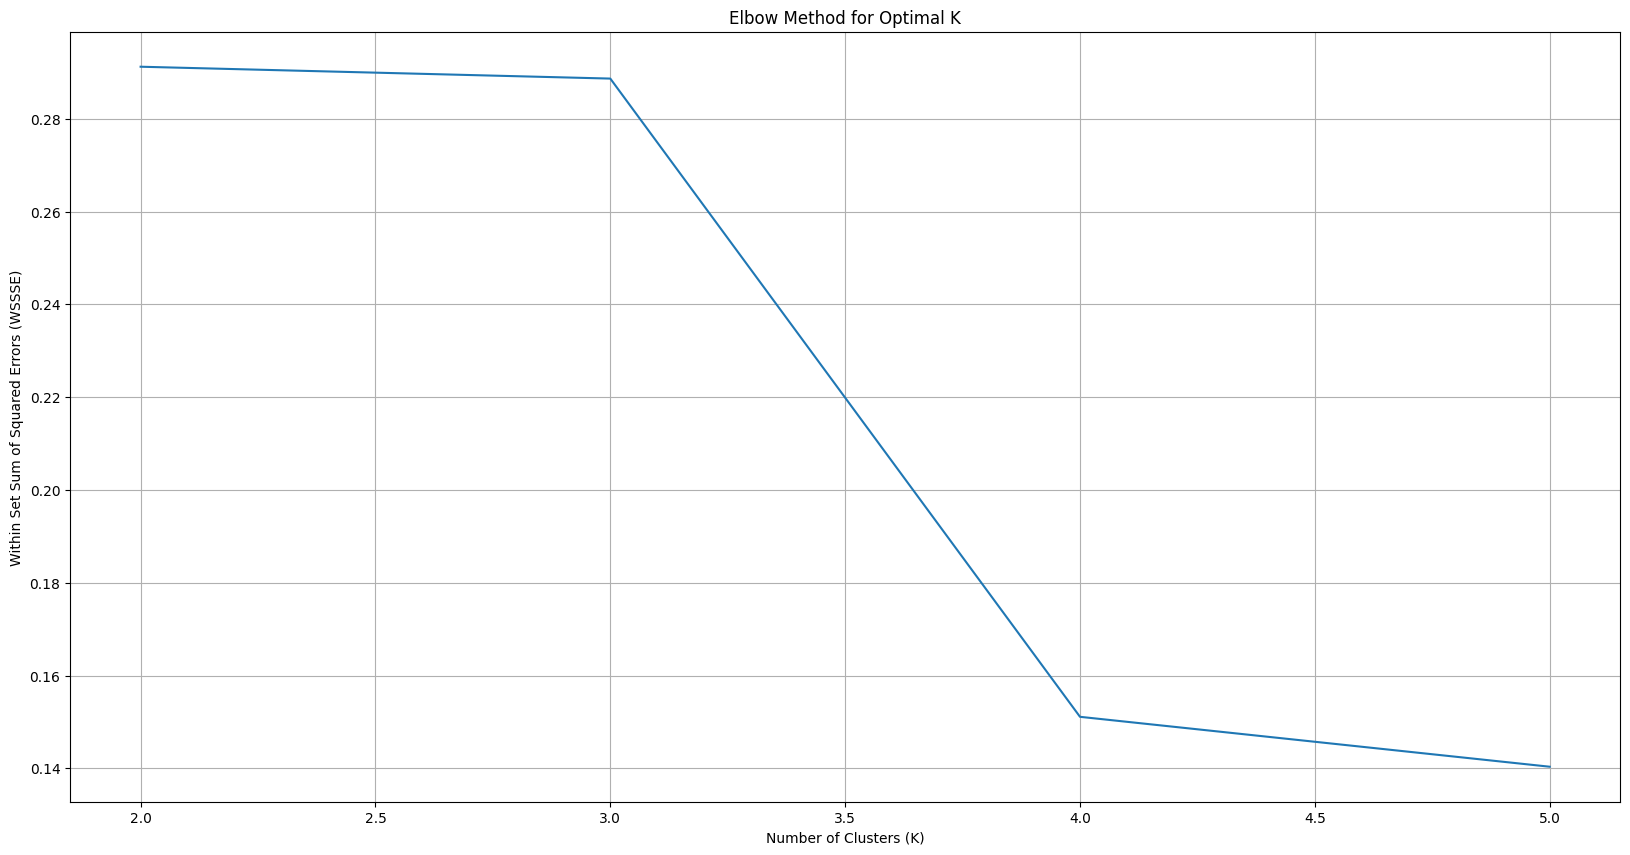

In [40]:
# Plotting WSSSE values
plt.plot(range(2, 6), wssse_values)
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within Set Sum of Squared Errors (WSSSE)')
plt.title('Elbow Method for Optimal K')
plt.grid()
plt.show()

In [41]:
# Define the K-means clustering model
kmeans = KMeans(k=4, featuresCol="scaled_features", predictionCol="cluster")
kmeans_model = kmeans.fit(data_df)


# Assigning the data points to clusters
clustered_data = kmeans_model.transform(data_df)


In [42]:
output = KMeans_fit.transform(data_df)
wssse = evaluator.evaluate(output)
print(f"Within Set Sum of Squared Errors (WSSSE) = {wssse}")

Within Set Sum of Squared Errors (WSSSE) = 0.1403369090634606


In [50]:
cd = clustered_data.toPandas().to_csv("Clustered")